# Driver Drowsiness Classification
The goal of this notebook is to perform classification on my created features using Support Vector Machines. 
And to experiment with the segment length untill classification cannot be performed correctly anymore.

In [1]:
import seaborn as sns
from sklearn.svm import SVC
from helping_functions import *
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def get_data(subject, treshhold, segment_length):
    status_rates_sleepy, wrong_frames_sleepy = load_blinks(subject, 'sleepy') 
    #print("Sleepy number of frames: ", len(status_rates_sleepy))
    #print("Sleepy missed faces: ", len(wrong_frames_sleepy))
    status_rates_normal, wrong_frames_normal = load_blinks(subject, 'normal') 
    #print("Normal number of frames: ", len(status_rates_normal))
    #print("Normal missed faces: ", len(wrong_frames_normal))
    
    print("Starting segmenting normal condition")
    blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length)

    print("Starting segmenting sleepy condition")
    blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length)
    
    return list(zip(blink_counts_normal, average_durs_normal)), list(zip(blink_counts_sleepy, average_durs_sleepy))

In [3]:
def train_model(X_normal, X_sleepy):
    y_normal = list(np.zeros(len(X_normal)))
    y_sleepy = list(np.ones(len(X_sleepy)))

    X = X_normal + X_sleepy
    y = y_normal + y_sleepy

    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    #print("Maximum values :", scaler.data_max_)
    #print("Minimum values :", scaler.data_min_)

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3,random_state=41)
    
    # train model
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_round =  round(f1, 2) 
    print("F1 score: ", f1_round)


    return model, f1_round, X_train, X_test, y_train, y_test

## Training models for multiple segment lengths

In [7]:
def multi_seg_lens(subject, treshhold, min_list):
    models = []
    f1_scores = []
    for minutes in min_list:
        print("Segment length: " + str(minutes))
        segment_length = int(2760 * minutes)
        X_normal, X_sleepy = get_data(subject, treshhold, segment_length)
        model, f1_round, X_train, X_test, y_train, y_test = train_model(X_normal, X_sleepy)
        f1_scores.append(f1_round)
        models.append(model)
    return models, f1_scores

subject = 'subject16'
treshhold = 10
min_list = [0.2,1,2,5,8]

models, f1_scores = multi_seg_lens(subject, treshhold, min_list)
print(f1_scores)

Segment length: 0.2


NameError: name 'load_blinks' is not defined

In [1]:
def plot_multi_seg(subject, min_list, f1_scores):
    x_values = range(len(min_list))
    plt.plot(x_values, f1_scores)
    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.title('Classification performance for '+ subject + ' when increasing segment length')
    plt.show()
    
plot_multi_seg(subject, min_list, f1_scores)

NameError: name 'subject' is not defined

## Multiple subjects classification (subject-individually)

In [30]:
def multi_subjects(subjects, threshold, min_list):
    sum_f1_scores = np.zeros(len(min_list))
    all_f1_scores = []
    for sub in subjects:
        subject = 'subject' + str(sub)
        f1_scores = multi_seg_lens(subject, threshold, min_list)[1]
        all_f1_scores.append(f1_scores)
        sum_f1_scores = sum_f1_scores + np.array(f1_scores)
        print("SUBJECT" + str(sub)+ " DONE", f1_scores)
    avg_f1_scores = sum_f1_scores / len(subjects)

    x_values = range(len(min_list))
    plt.plot(x_values, list(avg_f1_scores))
    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.title('Classification performance for all subjects when increasing segment length')
    plt.savefig('../final_figures/class_f1_analysis_poly.jpg')
    plt.show()
    return all_f1_scores, avg_f1_scores

In [ ]:
subjects = [1,3,4,6,7,9,10,12,14,15,22,23,24]

threshold = 10
min_list = [0.1,0.5,1,2,5]
scores, avg_scores = multi_subjects(subjects, threshold, min_list)

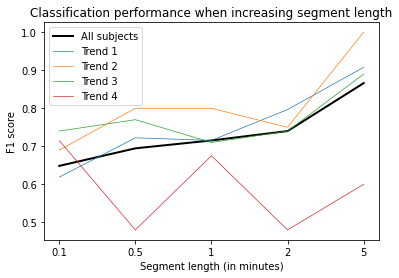

In [34]:
# because of too little semgments, subjects 11,16, 20 and 25 are removed
trends = {'1':[3,4,6,9,10,14,15,23,24], '2':[1], '3':[7], '4':[12,22]}
def plot_performance_trends(scores, avg_scores, trends, min_list):
    x_values = range(len(min_list))
    
    # plotting performance for all trends
    plt.plot(x_values, list(avg_scores), label = "All subjects", linewidth = 2, color='black')
    
    # plotting performances across trends individually
    for t in range(1,5):
        idx = [subjects.index(sub) for sub in trends[str(t)]]
        trend_scores = np.array(scores)[idx]
        trend_mean = np.mean(trend_scores, axis=0)
        plt.plot(x_values, list(trend_mean), label = 'Trend ' + str(t), linewidth=0.7)
    

    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.legend()
    plt.title('Classification performance when increasing segment length')
    plt.savefig('../final_figures/class_f1_analysis_trends.jpg')
    plt.show()
    
plot_performance_trends(scores, avg_scores, trends, min_list)

## Training 1 model

In [244]:
# Choose which subject
subject = 'subject1'

# Parameters
treshhold = 10
minutes = 1
segment_length = int(2760) * minutes


X_normal, X_sleepy = get_data(subject, treshhold, segment_length)

STARTING SEGMENTING NORMAL CONDITION
Number of blinks:  3731
0
30000
60000
90000
120000
150000
Number of segments 58
Mean blink count per segment 63.36206896551724
Mean blink duration per segment 3.554221180109667
STARTING SEGMENTING SLEEPY CONDITION
Number of blinks:  2545
0
30000
60000
90000
120000
Number of segments 53
Mean blink count per segment 46.58490566037736
Mean blink duration per segment 5.9381806401380155


In [240]:
model, f1_round, X_train, X_test, y_train, y_test = train_model(X_normal, X_sleepy)

F1 score:  0.8
SVC(kernel='linear')
0.8


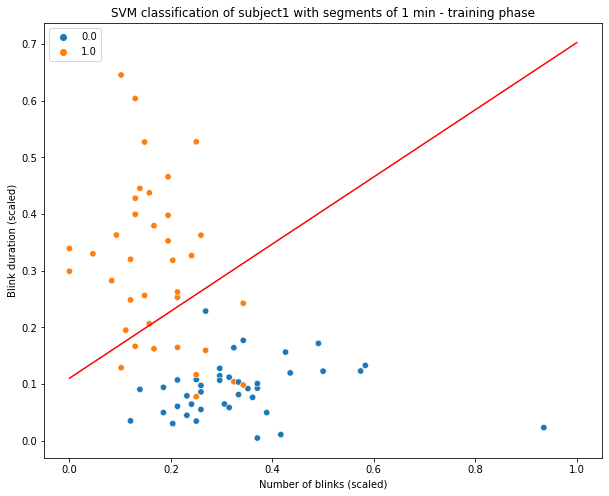

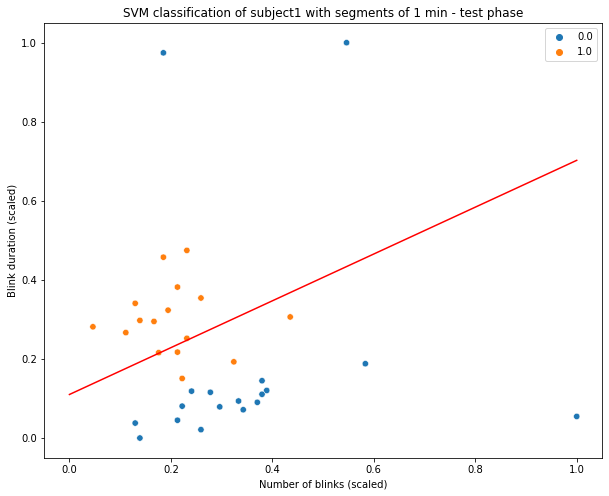

In [241]:
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=X_train[:, 0], 
                y=X_train[:, 1], 
                hue=y_train, 
                s=40);

w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(0, 1)
y_points = -(w[0] / w[1]) * x_points - b / w[1]

# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');
plt.xlabel('Number of blinks (scaled)')
plt.ylabel('Blink duration (scaled)')
plt.title('SVM classification of ' + subject + ' with segments of ' + str(minutes) + ' min - training phase')
#plt.savefig('../figures/svm_' + subject + '_min' + str(minutes) + '-training.jpg')
plt.show()


# Testing phase
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=X_test[:, 0], 
                y=X_test[:, 1], 
                hue=y_test, 
                s=40);

w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(0, 1)
y_points = -(w[0] / w[1]) * x_points - b / w[1]

# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');

# Plotting textbox with F1 score
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(0.05, 1, "F1 score : " + str(f1_round), fontsize=12,
        #verticalalignment='top', bbox=props)

plt.xlabel('Number of blinks (scaled)')
plt.ylabel('Blink duration (scaled)')
plt.title('SVM classification of ' + subject + ' with segments of ' + str(minutes) + ' min - test phase')
#plt.savefig('../figures/svm_' + subject + '_min' + str(minutes) + '-test.jpg')
plt.show()

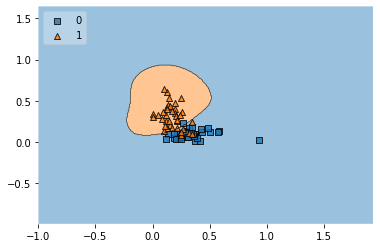

F1 score rbf:  0.9


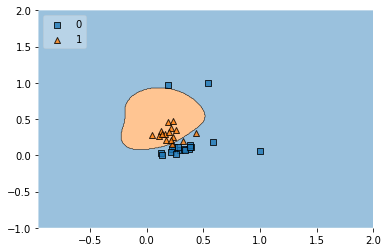

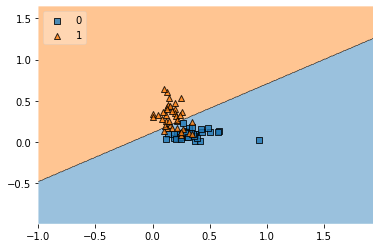

F1 score lin:  0.8


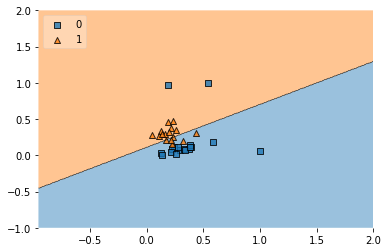

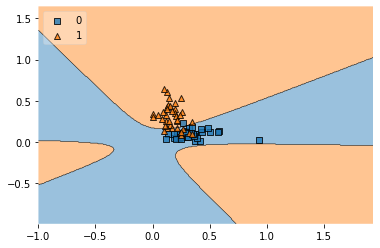

F1 score poly:  0.88


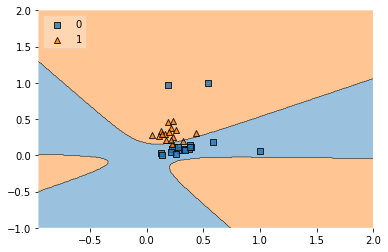

In [237]:
from mlxtend.plotting import plot_decision_regions

model_rbf =  SVC(kernel='rbf')
model_rbf.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_rbf, legend=2)
plt.show()

y_pred = model_rbf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score rbf: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_rbf, legend=2)
plt.show()

model_lin =  SVC(kernel='linear')
model_lin.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_lin, legend=2)
plt.show()

y_pred = model_lin.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score lin: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_lin, legend=2)
plt.show()

model_poly =  SVC(kernel='poly')
model_poly.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_poly, legend=2)
plt.show()

y_pred = model_poly.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score poly: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_poly, legend=2)
plt.show()

# General classification (all subjects with 1 model)

In [7]:
import random
from collections import Counter

def gen_classification(subjects, threshold, segment_length, test_subjects, subject_test_split=False):
    if subject_test_split:
        subjects = list(map(str, subjects))
        if test_subjects:
            test_subs = list(map(str, test_subjects))
        else:
            num_test_subs = int(0.3 * len(subjects))
            test_subs = random.sample(subjects, k=num_test_subs)
        train_subs = list((Counter(subjects)-Counter(test_subs)).elements())
        print(train_subs)
        print(test_subs)
        
        first = True
        for sub in train_subs:
            subject = 'subject' + sub
            if first:
                X_normal_train, X_sleepy_train = get_data(subject, threshold, segment_length)
                X_normal_train = np.array(X_normal_train)
                X_sleepy_train = np.array(X_sleepy_train)
                first = False
            else:
                new_X_normal, new_X_sleepy = get_data(subject, threshold, segment_length)
                X_normal_train = np.concatenate((X_normal_train, np.array(new_X_normal)), axis=0)
                X_sleepy_train = np.concatenate((X_sleepy_train, np.array(new_X_sleepy)), axis=0)
       
        first = True
        for sub in test_subs:
            subject = 'subject' + sub
            if first:
                X_normal_test, X_sleepy_test = get_data(subject, threshold, segment_length)
                X_normal_test = np.array(X_normal_test)
                X_sleepy_test = np.array(X_sleepy_test)
                first = False
            else:
                new_X_normal, new_X_sleepy = get_data(subject, threshold, segment_length)
                X_normal_test = np.concatenate((X_normal_test, np.array(new_X_normal)), axis=0)
                X_sleepy_test = np.concatenate((X_sleepy_test, np.array(new_X_sleepy)), axis=0)
        
        y_normal_train = list(np.zeros(len(X_normal_train)))
        y_normal_test = list(np.zeros(len(X_normal_test)))
        
        y_sleepy_train = list(np.ones(len(X_sleepy_train)))
        y_sleepy_test = list(np.ones(len(X_sleepy_test)))
        
          
        X_normal = X_normal_train.tolist() + X_normal_test.tolist()
        X_sleepy = X_sleepy_train.tolist() + X_sleepy_test.tolist()
        
        X = X_normal + X_sleepy
         
        train_normal_end = len(X_normal_train)
        test_normal_end = len(X_normal_test) + train_normal_end
        
        train_sleepy_end = len(X_sleepy_train) + test_normal_end

        scaler = MinMaxScaler()
        X_norm = scaler.fit_transform(X)
        
        norm_X_normal_train = X_norm[:train_normal_end]
        norm_X_normal_test = X_norm[train_normal_end:test_normal_end]
        norm_X_sleepy_train = X_norm[test_normal_end:train_sleepy_end]
        norm_X_sleepy_test = X_norm[train_sleepy_end:]

        print(len(X_normal_train), len(norm_X_normal_train))
        print(len(X_normal_test), len(norm_X_normal_test))
        print(len(X_sleepy_train), len(norm_X_sleepy_train))
        print(len(X_sleepy_test), len(norm_X_sleepy_test))
        
        y_train = y_normal_train + y_sleepy_train
        y_test = y_normal_test + y_sleepy_test
        
        X_train = norm_X_normal_train.tolist() + norm_X_sleepy_train.tolist()
        X_test = norm_X_normal_test.tolist() + norm_X_sleepy_test.tolist()
        
        # train model
        model = SVC(kernel='poly')
        model.fit(np.array(X_train), y_train)

        y_pred = model.predict(np.array(X_test))
        f1 = f1_score(y_test, y_pred)
        f1_round =  round(f1, 2) 
        print("F1 score: ", f1_round)
        return model, f1_round, X_train, X_test, y_train, y_test
        
    else:
        first = True
        for sub in subjects:
            subject = 'subject' + str(sub)
            if first:
                X_normal, X_sleepy = get_data(subject, threshold, segment_length)
                X_normal = np.array(X_normal)
                X_sleepy = np.array(X_sleepy)
                first = False
            else:
                new_X_normal, new_X_sleepy = get_data(subject, treshhold, segment_length)
                X_normal = np.concatenate((X_normal, np.array(new_X_normal)), axis=0)
                X_sleepy = np.concatenate((X_sleepy, np.array(new_X_sleepy)), axis=0)
                
        model, f1_round, X_train, X_test, y_train, y_test =  train_model(X_normal, X_sleepy)  
        return model, f1_round, X_train, X_test, y_train, y_test

def k_fold_class(k, subjects, threshold, seg_len, test_subjects=None, subject_test_split=True,):
    sum_f1 = 0
    for i in range(k):
        model, f1_round, X_train, X_test, y_train, y_test = gen_classification(subjects, threshold, seg_len, test_subjects, subject_test_split=True)
        sum_f1 += f1_round
    return sum_f1 / k
    

subjects = [9,10, 11, 12, 14,15,16,20,23,24, 25]
test_subjects = [10, 15, 12]

subjects_trend1 = [3,4,9,10,14,15,23,24]
subjects_trend2 = [1]
subjects_trend3 = [7, 16, 20, 25]
subjects_trend4 = [11, 12, 22]

threshold = 10
seg_len = 2760

#model, f1_round, X_train, X_test, y_train, y_test = gen_classification(subjects_trend1, threshold, seg_len, subject_test_split=True)
f1 = k_fold_class(1, subjects, threshold, seg_len, test_subjects, subject_test_split=True)
print("Average F1 score ", f1)

['9', '11', '14', '16', '20', '23', '24', '25']
['10', '15', '12']
Starting segmenting normal condition
Number of segments 11
Starting segmenting sleepy condition
Number of segments 15
Starting segmenting normal condition
Number of segments 70
Starting segmenting sleepy condition
Number of segments 43
Starting segmenting normal condition
Number of segments 18
Starting segmenting sleepy condition
Number of segments 42
Starting segmenting normal condition
Number of segments 52
Starting segmenting sleepy condition
Number of segments 19
Starting segmenting normal condition
Number of segments 8
Starting segmenting sleepy condition
Number of segments 59
Starting segmenting normal condition
Number of segments 35
Starting segmenting sleepy condition
Number of segments 20
Starting segmenting normal condition
Number of segments 50
Starting segmenting sleepy condition
Number of segments 32
Starting segmenting normal condition
Number of segments 62
Starting segmenting sleepy condition
Number of se

# Statistical Validation

In [29]:
from scipy import stats
def wilcoxon_test(normal_vals, sleepy_vals):
    w_score = stats.wilcoxon(normal_vals, sleepy_vals)
    return w_score[0], w_score[1]


def equally_sized_lists(list1, list2):
    if len(list1) > len(list2):
        list1 = list1[:len(list2)]
    elif len(list1) < len(list2):
        list2 = list2[:len(list1)]
    return list1, list2

def wilcoxon_check(subjects, treshhold, segment_length):
    sum_score = 0
    w_scores = []
    for sub in subjects:
        subject = 'subject' + str(sub)
        status_rates_sleepy, wrong_frames_sleepy = load_blinks(subject, 'sleepy') 
        status_rates_normal, wrong_frames_normal = load_blinks(subject, 'normal') 
        blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length)
        blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length)
    
        blink_counts_normal, blink_counts_sleepy = equally_sized_lists(blink_counts_normal, blink_counts_sleepy)
        average_durs_normal, average_durs_sleepy = equally_sized_lists(average_durs_normal, average_durs_sleepy)
        normal_concat = np.concatenate((blink_counts_normal, average_durs_normal))
        sleepy_concat = np.concatenate((blink_counts_sleepy, average_durs_sleepy))
        print(normal_concat.shape, sleepy_concat.shape)
        w_score = wilcoxon_test(normal_concat, sleepy_concat)
        sum_score += w_score[1]
        print(w_score[1])
        w_scores.append(w_score[1])
        print("Done with subject " + str(sub))

    print("mean: ", np.mean(np.array(w_scores)))
    return (sum_score / len(subjects)), w_scores

subjects = [1,3,4,6,7,14,15,16,20,23,24]
avg_wil, w_scores = wilcoxon_check(subjects, 10, 46 * 60)
print("Average wilcoxon p-value for the first two principal components combined: ", avg_wil)

Number of segments 58
Number of segments 53
(106,) (106,)
0.021347854704395427
Done with subject 1
Number of segments 54
Number of segments 27
(54,) (54,)
4.190245775850848e-10
Done with subject 3
Number of segments 47
Number of segments 58
(94,) (94,)
3.777509948410078e-14
Done with subject 4
Number of segments 46


KeyboardInterrupt: 

In [35]:
#w_scores.remove(0.7593226504421547)
print(np.mean(np.array(w_scores)))

0.0024494486689699895
